<a href="https://colab.research.google.com/github/PetchMa/DeepSearch/blob/master/SETI_Unsupervised_injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **SETI CNN-LSTM AE Anomoly Detection** 
*Author Peter Ma : peterxiangyuanma@gmail.com*

## ***Abstract***

*The purpose of this notebook is to propose a Deep CNN LSTM AE that can help detect anomalies within the GBT dataset from Breakthrough Listen. The code demonstrates a concept that appears hopeful in accelerating SETI detection in large unlabeled datasets. This approach is an extension from the original paper [https://arxiv.org/pdf/1901.04636.pdf] by looking into preforming the final classification on the encoded feature vector using a K-means clustering algorithm to reduce the effects of NFL Theorem issues that may arise from the dimensionality reduction. Furthermore, this model neglects the effects of high SNR as the trained data is assumed to be "normal" and the SETIGEN signal as abnormal. This assumption renders the issues between background noise and SETI signals benign.*

________________________________________________________________________________





# Preliminary

***Getting things sorted out.***

We mount Google Drive content to the Colab Notebook. Runs a on a host with 25GB RAM and Nvidia Tesla T4

The needed libraries for the project follows the Tensorflow and Keras framework.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \
#   --port=9090 --no-browser

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
pip install blimpy

     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 3.4MB 8.3MB/s 


In [3]:
import tensorflow as tf 
import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, ConvLSTM2D
from keras.layers.core import Activation, Flatten
import matplotlib.pyplot as plt
from keras.optimizers import SGD,RMSprop,adam
from keras.models import load_model
from sklearn.utils import shuffle
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import os, os.path
import numpy as np
import tempfile
import scipy.io.wavfile
from keras.layers import Reshape
from keras import losses
from keras.layers.advanced_activations import LeakyReLU
from scipy.io import wavfile
from keras.layers import Input, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
from keras import backend as K
from keras.layers.convolutional import Convolution1D
from keras.layers import  Conv2D, MaxPool3D, MaxPooling2D, TimeDistributed, Embedding, Convolution2D , Lambda
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import pylab as plt
from blimpy import Waterfall
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization, ZeroPadding2D
from astropy import units as u
from keras.layers import Softmax
from  keras.backend import expand_dims


Using TensorFlow backend.


blimpy.waterfall WARNING  Could not import bitshuffle, using hdf5plugin failover. Write access disabled.


In [4]:
pip install setigen 

     |████████████████████████████████| 6.3MB 3.7MB/s 
     |████████████████████████████████| 25.2MB 1.3MB/s 
     |████████████████████████████████| 13.0MB 21.2MB/s 
     |████████████████████████████████| 17.3MB 206kB/s 
     |████████████████████████████████| 6.4MB 38.7MB/s 
  Created wheel for blimpy: filename=blimpy-1.3.5-cp36-none-any.whl size=48797 sha256=b96a3aa9ad4621e800a75d7c621933abfcd5da8d37c66fd8ec56cc328b6cc270
  Stored in directory: /root/.cache/pip/wheels/3b/c5/7e/021ef6f602623a64418a6675b46a4fdddbe9f4251b38453cef
Successfully built blimpy
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which i

In [5]:
from random import seed
from random import random
from astropy import units as u
import setigen as stg

astropy         WARNING  AstropyDeprecationWarning: The InheritDocstrings class is deprecated and may be removed in a future version.
        Use Sphinx>=1.7 automatically inherits docstring instead.


        Use Sphinx>=1.7 automatically inherits docstring instead. [astropy.timeseries.binned]


# **Data Loading**

This small data set contains a snippet of 1 big file [277, 1, 262144] which can be spliced into smaller sequences [3276, 256, 1, 64] where it *sample vs time vs intensity vs freq*. This spliced data will not affect the appearances of SETI signals since even max doppler shifts are 50Hz at max which is within the channel range of 64 frequencies 

In [6]:
%matplotlib inline
file_path = '/content/drive/My Drive/Deeplearning/Information/test.h5'
obs = Waterfall(file_path, max_load=5)
obs.info()
data = obs.data
# obs.plot_spectrum(logged=True)
normalize = (data.argmax()*10)
data = obs.data / normalize
print(data)

blimpy.io.file_wrapper WARNING  Setting data limit > 1GB, please handle with care!

--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
 b'telescope_id' :                                6
        b'nbits' :                               32
         b'fch1' :                    1876.46484375
    b'data_type' :                                1
       b'nchans' :                           262144
        b'tsamp' :                      1.058013184
         b'foff' :             -0.00286102294921875
      b'src_raj' :                      12h05m50.6s
      b'src_dej' :                   -15d48m04.027s
   tstart (ISOT) :          2016-03-07T08:18:25.000
    tstart (MJD) :                57454.34612268519
     b'az_start' :                              0.0
  b'source_name' :                  b'HIP59000_OFF'
     b'za_start' :                              0.0
   b'machine_id' :                               20
         b'nifs' :                                1

Num ints 

In [0]:
# from astropy import units as u
# start = 1023.92578125
# end = start + 64 *0.0028610
# obs.plot_waterfall(f_start=start, f_stop=end)

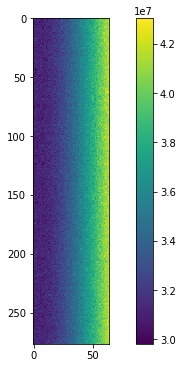

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.imshow( obs.data[:,0,0:64])
plt.colorbar()
fig.savefig("sine_signal.png", bbox_inches='tight')

## Prepare Data For Unsupervised DL

In [8]:
num_channels = 64
# Cut the time down to 256 seconds
data = data[:256,:,:]
num_section = int(data.shape[2]/num_channels)
unsupervised_data_normal = np.zeros((num_section,data.shape[0],1, num_channels), dtype=float)
for i in range(1,num_section):
  unsupervised_data_normal[i,:,:,:] += data[:,:,(i-1)*num_channels:i*num_channels]

# Test training split.
unsupervised_temp = shuffle(unsupervised_data_normal, random_state=3)
X_train_unsupervised, X_test_unsupervised, y_train_unsupervised, y_test_unsupervised = train_test_split(unsupervised_temp, unsupervised_temp, test_size=0.2, random_state=2)
print(unsupervised_data_normal.shape)

(4096, 256, 1, 64)


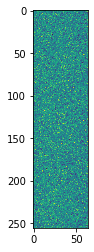

In [9]:
imgplot = plt.imshow(X_train_unsupervised[1,:,0,0:64])

## Supervised Learning Dataset Preperation

(8192, 2)
(8192, 256, 1, 64)
(8192, 256, 1, 64)


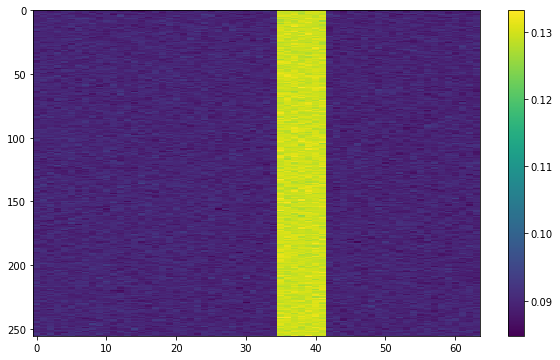

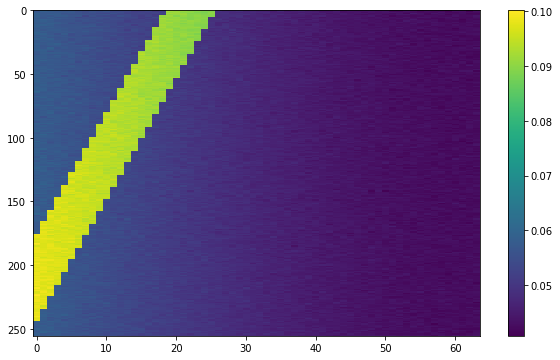

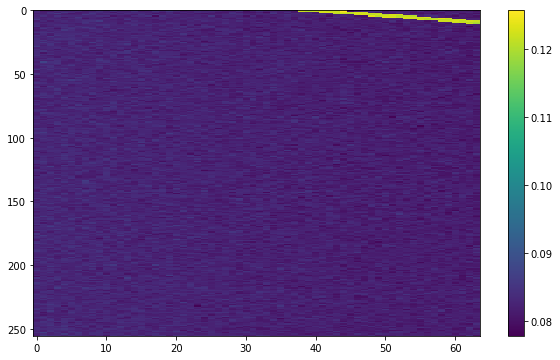

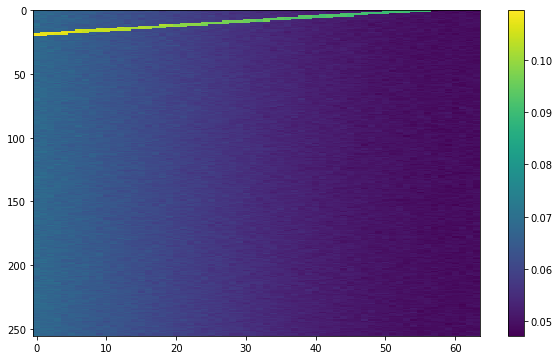

In [10]:
# Prepare the normal dataset
num_channels = 64
data = data[:256,:,:]
num_section = int(data.shape[2]/num_channels)
data_normal = np.zeros((num_section,data.shape[0],1, num_channels), dtype=float)
for i in range(1,num_section):
  data_normal[i,:,:,:] += data[:,:,(i-1)*num_channels:i*num_channels]


# Prepare the target set

fchans = 64
tchans = 256
df = 2.7939677238464355*u.Hz
dt = 18.25361108*u.s
fch1 = 6095.214842353016*u.MHz

generated_signals = np.zeros((num_section,data_normal.shape[1],1, num_channels), dtype=float)


for i in range(1,data_normal.shape[0]):
  base = data_normal[i,:,0,:] 
  start = int(random()*60)
  frame= stg.Frame(fchans, tchans, df, dt, fch1)
  signal = frame.add_signal(stg.constant_path(f_start=frame.fs[start],
                                              drift_rate=(random()-0.5)*10**int(random()*-2) *u.Hz/u.s),
                            stg.constant_t_profile(level=0.2),
                            stg.box_f_profile(width=20*u.Hz),
                            stg.constant_bp_profile(level=0.2))

  artifical_radio = frame.get_data()
  artifical_radio = np.add(base, artifical_radio)
  artifical_radio = np.reshape(artifical_radio, (256,1,64))
  generated_signals[i,:,:,:]= artifical_radio

  if i %1000 ==0:
    fig = plt.figure(figsize=(10, 6))
    plt.imshow(generated_signals[i,:,0,:], aspect='auto')
    plt.colorbar()
    fig.savefig("test.png", bbox_inches='tight')


# Label the dataset
supervised_true =  np.concatenate((np.ones((generated_signals.shape[0],1),dtype='int64'),np.zeros((generated_signals.shape[0],1),dtype='int64')), axis=1)
supervised_false = np.concatenate((np.zeros((data_normal.shape[0],1),dtype='int64'),np.ones((data_normal.shape[0],1),dtype='int64')), axis=1)
label = np.concatenate((supervised_true, supervised_false))
supervised_dataset = np.concatenate((generated_signals, data_normal))
print(label.shape)
print(supervised_dataset.shape)
# Test training split.

X_train_supervised, X_test_supervised, y_train_supervised, y_test_supervised = train_test_split(supervised_dataset, label, test_size=0.2, random_state=2)
print(supervised_dataset.shape)

In [11]:
  LR = LeakyReLU(0.3)
  LR.__name__ = 'relu'

  def expand_dims(x):
    return K.expand_dims(x, -1)


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



# **Encoder Injection Training**

In [12]:
input_shape = data_normal[0].shape
layer_filters = [32, 64,128]
kernel_size = 30
latent_dim = 12
time = int(data_normal.shape[1])
filters = layer_filters[1]*2

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               padding='same', kernel_initializer='glorot_normal')(x)
    # x = MaxPooling2D(2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters=256,
            kernel_size=kernel_size,
            strides=1,
            padding='same', kernel_initializer='glorot_normal')(x)
# x = MaxPooling2D(8)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((time, time))(x)
shape = K.int_shape(x)
x = CuDNNLSTM(256, return_sequences=True, input_shape=(shape))(x)
x = CuDNNLSTM(256, return_sequences=True, input_shape=(shape))(x)
shape = K.int_shape(x)
encoder = Model(inputs, x, name='encoder')
encoder.summary()
print(shape)


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


ten

In [13]:
latent_inputs = Input(shape=(shape[1],shape[2]), name='fully_connected_inputs')
x = Flatten()(latent_inputs)
x = Dense(64)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(2)(x)
x = Softmax()(x)
fully_connected = Model(latent_inputs, x, name='encoder')
fully_connected.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fully_connected_inputs (Inpu (None, 256, 256)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4194368   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
softmax_1 (Softmax)          (None, 2)                 0         
Total params: 4,194,498
Trainable params: 4,194,498
Non-trainable params: 0
_________________________________________________

In [14]:
from keras.optimizers import SGD,RMSprop,Adam
sgd = SGD(lr=0.01, clipnorm=1, clipvalue=0.5)

encoder = Model(inputs, encoder(inputs), name='Encoder_injection') 

encoder_final = Model(inputs, fully_connected(encoder(inputs)), name='encoder_training')

encoder_final.summary()

Model: "encoder_training"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 256, 1, 64)        0         
_________________________________________________________________
Encoder_injection (Model)    (None, 256, 256)          41605472  
_________________________________________________________________
encoder (Model)              (None, 2)                 4194498   
Total params: 45,799,970
Trainable params: 45,799,010
Non-trainable params: 960
_________________________________________________________________


In [0]:
encoder_final.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['acc'])

mc = ModelCheckpoint('encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = encoder_final.fit(X_train_supervised, y_train_supervised, batch_size=20, epochs=5, validation_data=(X_test_supervised, y_test_supervised), callbacks=[mc])

Train on 6553 samples, validate on 1639 samples
Epoch 1/5
6553/6553 [==============================] - 103s 16ms/step - loss: 0.1003 - acc: 0.8659 - val_loss: 0.3027 - val_acc: 0.5156
Epoch 2/5
6553/6553 [==============================] - 98s 15ms/step - loss: 0.0352 - acc: 0.9573 - val_loss: 0.2233 - val_acc: 0.5888
Epoch 3/5
6553/6553 [==============================] - 98s 15ms/step - loss: 0.0232 - acc: 0.9725 - val_loss: 0.0231 - val_acc: 0.9841
Epoch 4/5
6553/6553 [==============================] - 98s 15ms/step - loss: 0.0212 - acc: 0.9716 - val_loss: 0.3031 - val_acc: 0.5406
Epoch 5/5
6553/6553 [==============================] - 98s 15ms/step - loss: 0.0176 - acc: 0.9774 - val_loss: 0.1947 - val_acc: 0.6437


In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

NameError: ignored

# **Convolutional Long Short Term Memory Autoencoder**

This is model is built using Keras and takes in an input of a sample and convolves the entire input into smaller features which is then read through the LSTM preforming the final encoding by propagating through time.

Below the is the Encoder for the model.

In [19]:

# input_shape = data_splice[0].shape
# layer_filters = [32, 64, 128]
# kernel_size = 30
# latent_dim = 12
# time = int(info.shape[1])

# inputs = Input(shape=input_shape, name='encoder_input')
# x = inputs
# for filters in layer_filters:
#     x = Conv2D(filters=filters,
#                kernel_size=kernel_size,
#                strides=1,
#                padding='same', kernel_initializer='glorot_normal')(x)
#     # x = MaxPooling2D(2)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
# x = Conv2D(filters=256,
#             kernel_size=kernel_size,
#             strides=1,
#             padding='same', kernel_initializer='glorot_normal')(x)
# # x = MaxPooling2D(8)(x)
# x = BatchNormalization()(x)
# x = LeakyReLU(alpha=0.2)(x)
# x = Reshape((time, time))(x)
# shape = K.int_shape(x)
# x = CuDNNLSTM(256, return_sequences=True, input_shape=(shape))(x)
# x = CuDNNLSTM(256, return_sequences=True, input_shape=(shape))(x)
# x = Flatten()(x)
# latent = Dense(latent_dim, name='latent_vector')(x)
# encoder = Model(inputs, latent, name='encoder')
# encoder.summary()
# print(shape)

latent_inputs = Input(shape=(shape[1],shape[2]), name='fully_connected_inputs')
x = Flatten()(latent_inputs)
x = Dense(64)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(12)(x)
feature_encode = Model(latent_inputs, x, name='encoder')
feature_encode.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fully_connected_inputs (Inpu (None, 256, 256)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4194368   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                780       
Total params: 4,195,148
Trainable params: 4,195,148
Non-trainable params: 0
_________________________________________________________________


# **Decoder**

This section of the model decodes the latent features to attempt to reconstruct the original data. This forces the entire neural network to learn the important features of a normal data for reconstruction and thus when abnormal data is passed through it will be able to show its abnormality within the feature vector. 

In [20]:
layer_filters = [32, 64,128]
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2])(latent_inputs)
x = Reshape((shape[1], shape[2]))(x)
x = CuDNNLSTM(256, return_sequences=True, input_shape=(shape))(x)
x = CuDNNLSTM(256, return_sequences=True, input_shape=(shape))(x)
shape_1 = K.int_shape(x)
x = Reshape((shape_1[1], 1,  shape_1[2]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size, strides=1, padding='same' ,kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=1, padding='same' ,kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 65536)             851968    
_________________________________________________________________
reshape_4 (Reshape)          (None, 256, 256)          0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 256, 256)          526336    
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 256, 256)          526336    
_________________________________________________________________
reshape_5 (Reshape)          (None, 256, 1, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 256, 1, 128)       2949

In [21]:
from keras.optimizers import SGD,RMSprop,Adam
sgd = SGD(lr=100, clipnorm=1, clipvalue=0.5)



AutoEncoder = Model(inputs, decoder(feature_encode(encoder(inputs))), name='Generator')

# AutoEncoder.compile(loss='MSE',  optimizer=sgd,  metrics=['acc'])

AutoEncoder.summary()


Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 256, 1, 64)        0         
_________________________________________________________________
Encoder_injection (Model)    (None, 256, 256)          41605472  
_________________________________________________________________
encoder (Model)              (None, 12)                4195148   
_________________________________________________________________
decoder (Model)              (None, 256, 1, 64)        42456480  
Total params: 88,257,100
Trainable params: 88,255,564
Non-trainable params: 1,536
_________________________________________________________________


In [0]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        plt.savefig('SRCNN', dpi = None)        
plot_losses = PlotLosses()

# **Model Training**

The model preforms fairly well in terms of training and is able to bring down the pixel-wise loss to a very low score just after 20 epochs. 

In [0]:
AutoEncoder.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['acc'])

mc = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = AutoEncoder.fit(X_train_unsupervised, X_train_unsupervised,  batch_size=20, epochs=10, validation_data=(X_test_unsupervised, X_test_unsupervised), callbacks=[mc])

Train on 3276 samples, validate on 820 samples
Epoch 1/10
3276/3276 [==============================] - 110s 34ms/step - loss: 0.0766 - acc: 0.0353 - val_loss: 0.0244 - val_acc: 0.0489
Epoch 2/10
3276/3276 [==============================] - 103s 31ms/step - loss: 0.0244 - acc: 0.0582 - val_loss: 0.0089 - val_acc: 0.0532
Epoch 3/10
3276/3276 [==============================] - 103s 31ms/step - loss: 0.0161 - acc: 0.0613 - val_loss: 0.0046 - val_acc: 0.0532
Epoch 4/10
3276/3276 [==============================] - 103s 31ms/step - loss: 0.0133 - acc: 0.0613 - val_loss: 0.0028 - val_acc: 0.0532
Epoch 5/10
3276/3276 [==============================] - 103s 31ms/step - loss: 0.0121 - acc: 0.0613 - val_loss: 0.0019 - val_acc: 0.0532
Epoch 6/10
3276/3276 [==============================] - 103s 31ms/step - loss: 0.0114 - acc: 0.0613 - val_loss: 0.0014 - val_acc: 0.0532
Epoch 7/10
3276/3276 [==============================] - 103s 31ms/step - loss: 0.0110 - acc: 0.0613 - val_loss: 0.0011 - val_acc: 0

In [22]:
epoch = 10
sgd_encoder = SGD(lr=0.1, clipnorm=1, clipvalue=0.5)
sgd_unsupervised = SGD(lr=100, clipnorm=1, clipvalue=0.5)
encoder_final.compile(loss='mean_squared_error', optimizer=sgd_encoder,  metrics=['acc'])
AutoEncoder.compile(loss='mean_squared_error', optimizer=sgd_unsupervised,  metrics=['acc'])
for i in range(0,10):

  # encoder_final.compile(loss='mean_squared_error', optimizer=sgd_encoder,  metrics=['acc'])
  mc = ModelCheckpoint('encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True)
  history_encoder = encoder_final.fit(X_train_supervised, y_train_supervised, batch_size=20, epochs=1, validation_data=(X_test_supervised, y_test_supervised), callbacks=[mc])

  
  # AutoEncoder.compile(loss='mean_squared_error', optimizer=sgd_unsupervised,  metrics=['acc'])

  mc = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True)
  history_unsupervised = AutoEncoder.fit(X_train_unsupervised, X_train_unsupervised,  batch_size=20, epochs=1, validation_data=(X_test_unsupervised, X_test_unsupervised), callbacks=[mc])


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

Train on 6553 samples, validate on 1639 samples
Epoch 1/1
6553/6553 [==============================] - 107s 16ms/step - loss: 0.1415 - acc: 0.7905 - val_loss: 0.3178 - val_acc: 0.5516
Train on 3276 samples, validate on 820 samples
Epoch 1/1
3276/3276 [==============================] - 101s 31ms/step - loss: 0.0750 - acc: 0.0372 - val_loss: 0.0245 - val_acc: 0.0456
Train on 6553 samples, validate on 1639 samples
Epoch 1/1
6553/

In [0]:
from keras.models import load_model
model = load_model('setiENCODER.h5')


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


tensorflow      WARNING  From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


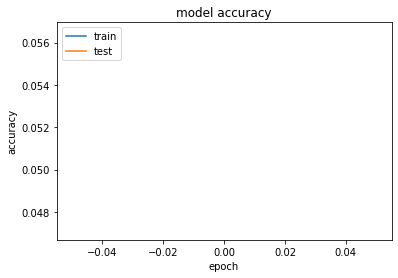

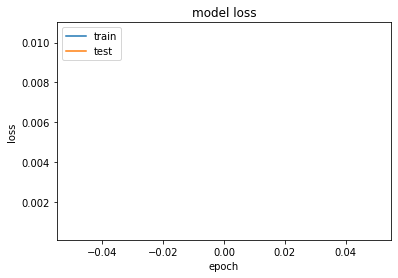

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


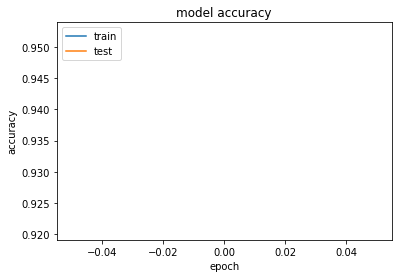

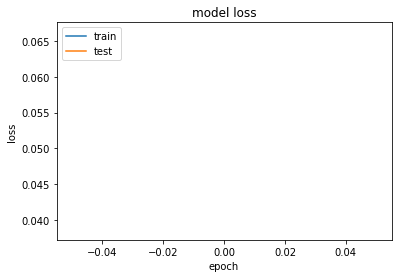

In [25]:
print(history_unsupervised.history.keys())
# summarize history for accuracy
plt.plot(history_unsupervised.history['acc'])
plt.plot(history_unsupervised.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_unsupervised.history['loss'])
plt.plot(history_unsupervised.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()


print(history_encoder.history.keys())
# summarize history for accuracy
plt.plot(history_encoder.history['acc'])
plt.plot(history_encoder.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_encoder.history['loss'])
plt.plot(history_encoder.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

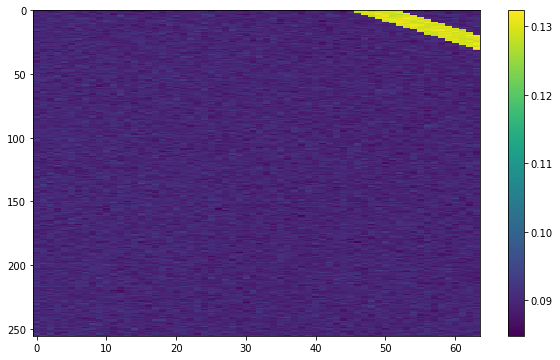

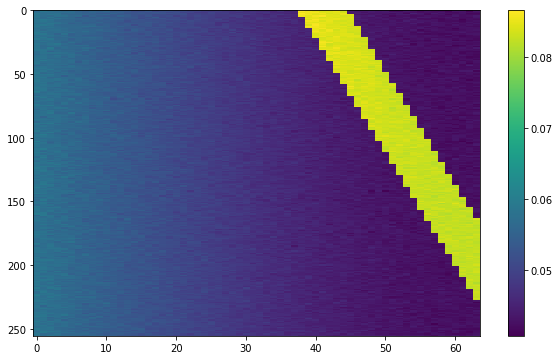

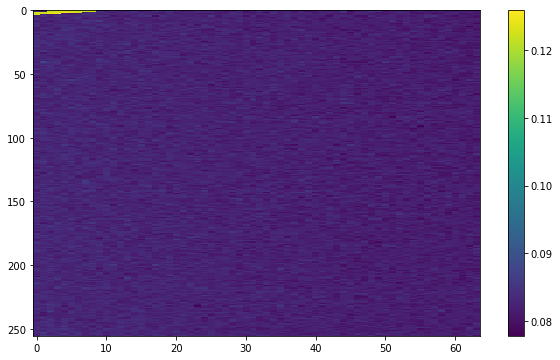

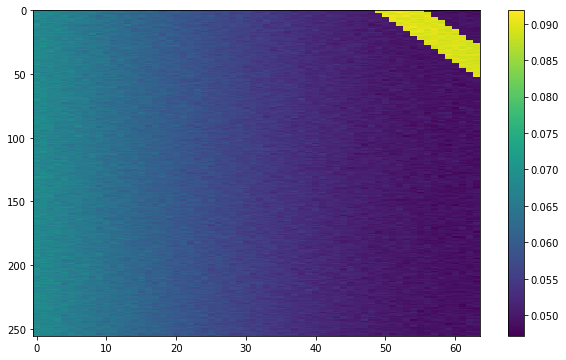

In [27]:
from random import seed
from random import random
from astropy import units as u
import setigen as stg

fchans = 64
tchans = 256
df = 2.7939677238464355*u.Hz
dt = 18.25361108*u.s
fch1 = 6095.214842353016*u.MHz

generated_signals = np.zeros((num_section,unsupervised_data_normal.shape[1],1, num_channels), dtype=float)


for i in range(1,data_normal.shape[0]):
  base = unsupervised_data_normal[i,:,0,:] 
  start = int(random()*60)
  frame= stg.Frame(fchans, tchans, df, dt, fch1)
  signal = frame.add_signal(stg.constant_path(f_start=frame.fs[start],
                                              drift_rate=(random()-0.5)*10**int(random()*-2) *u.Hz/u.s),
                            stg.constant_t_profile(level=0.2),
                            stg.box_f_profile(width=20*u.Hz),
                            stg.constant_bp_profile(level=0.2))
  # noise = frame.add_noise(x_mean=5, x_std=2)

  artifical_radio = frame.get_data()
  artifical_radio = np.add(base, artifical_radio)
  artifical_radio = np.reshape(artifical_radio, (256,1,64))
  # print(generated_signals.shape)
  generated_signals[i,:,:,:]= artifical_radio

  if i %1000 ==0:
    fig = plt.figure(figsize=(10, 6))
    plt.imshow(generated_signals[i,:,0,:], aspect='auto')
    plt.colorbar()
    fig.savefig("test.png", bbox_inches='tight')


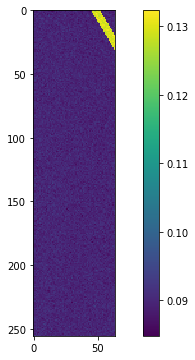

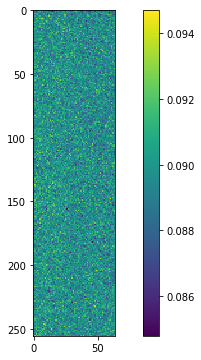

In [28]:
    fig = plt.figure(figsize=(10, 6))
    plt.imshow(generated_signals[1000,:,0,:])
    plt.colorbar()
    fig.savefig("test.png", bbox_inches='tight')

    fig = plt.figure(figsize=(10, 6))
    plt.imshow(unsupervised_data_normal[1000,:,0,:])
    plt.colorbar()
    fig.savefig("test.png", bbox_inches='tight')

In [29]:
encoder_injected = Model(inputs, feature_encode(encoder(inputs)), name='Generator')
encoder_injected.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 256, 1, 64)        0         
_________________________________________________________________
Encoder_injection (Model)    (None, 256, 256)          41605472  
_________________________________________________________________
encoder (Model)              (None, 12)                4195148   
Total params: 45,800,620
Trainable params: 45,799,660
Non-trainable params: 960
_________________________________________________________________


In [30]:
index1 = int(random()*50)
index2 = int(random()*50)
print(np.average(encoder_injected.predict(unsupervised_data_normal[index1:index1+1,:,:,:]) - encoder_injected.predict(unsupervised_data_normal[index2:index2+1,:,:,:]))**2)
print(np.average(encoder_injected.predict(unsupervised_data_normal[index1:index1+1,:,:,:]) - encoder_injected.predict(generated_signals[index2:index2+1,:,:,:]))**2 )

51.32319027361518
7.4820399125297286


In [31]:
ground_encode = encoder_injected.predict(unsupervised_data_normal)

artifical_encode = encoder_injected.predict(generated_signals)

total_data = np.concatenate((ground_encode,artifical_encode), axis=0)

print(total_data.shape)

(8192, 12)


In [32]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
def k_means_clustering_fit(inputdata, clusters):
  kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=3000, n_init=100, random_state=2)
  kmeans.fit(inputdata)
  generated = np.zeros((clusters))
  prediction =  kmeans.predict(inputdata)
  for i in range(0,inputdata.shape[0]):
    for k in range(0,clusters):
      if prediction[i]==k:
        generated[k]+=1
  print(generated)

  names = np.zeros((clusters))
  for t in range(0,clusters):
    names[t]=t
  plt.bar(names, generated)
  return prediction, kmeans, clusters

[1899.  995.  891.  431.  959.  818.  631.  173.   94. 1301.]


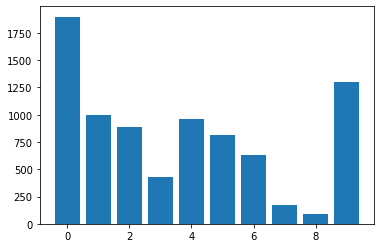

In [55]:
hold =[]
clusters = 10
hold, kmeans = k_means_clustering_fit(total_data, clusters)

10
[626. 540. 452. 408. 656. 433. 392. 170.  49. 370.]


<BarContainer object of 10 artists>

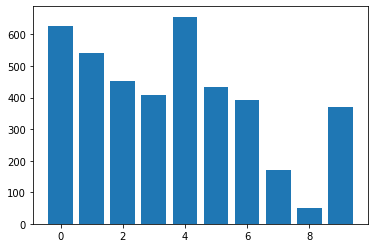

In [56]:

  # kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=3000, n_init=1000, random_state=2)
  # kmeans.fit(total_data)
  generated = np.zeros((clusters))
  prediction =  kmeans.predict(artifical_encode)
  print(clusters)
  for i in range(0,artifical_encode.shape[0]):
    for k in range(0,clusters):
      if prediction[i]==k:
        generated[k]+=1
  print(generated)

  names = np.zeros((clusters))
  for t in range(0,clusters):
    names[t]=t
  plt.bar(names, generated)

[1273.  455.  439.   23.  303.  385.  239.    3.   45.  931.]


<BarContainer object of 10 artists>

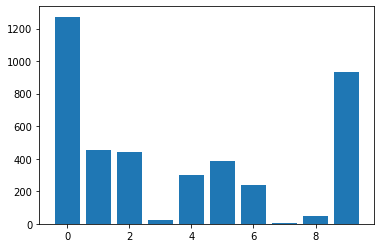

In [57]:
  generated = np.zeros((clusters))
  prediction =  kmeans.predict(ground_encode)
  for i in range(0,ground_encode.shape[0]):
    for k in range(0,clusters):
      if prediction[i]==k:
        generated[k]+=1
  print(generated)

  names = np.zeros((clusters))
  for t in range(0,clusters):
    names[t]=t
  plt.bar(names, generated)

In [0]:
def compute_distance(data, newdata):
  values= np.zeros(newdata.shape[0])
  print(newdata.shape[0]-1)
  for j in range(0, newdata.shape[0]-1):
    index = int(random()*newdata.shape[0])
    # print(j)
    values[j] = np.average(encoder_injected.predict(data[index:index+1,:,:,:]) - encoder_injected.predict(newdata[j:j+1,:,:,:]))**2
  return values

4095
4095
(8192,)
[139.0910949  269.69376516   0.48184642 ... 351.78204625  84.72568558
   0.        ]


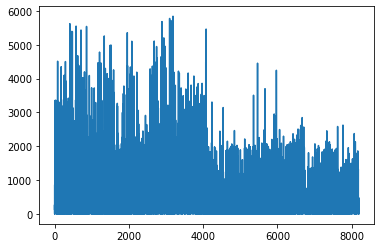

In [59]:
keep_track = np.concatenate((compute_distance(unsupervised_data_normal, generated_signals),compute_distance(unsupervised_data_normal, unsupervised_data_normal)), axis=0)

print(keep_track.shape)
print(keep_track)
# # keep_track = compute_distance(data_splice, generated_signals)
# names = np.zeros((keep_track.shape[0]))
# for t in range(0,keep_track.shape[0]):
#   names[t]=t
# plt.bar(names, keep_track)
plt.plot(keep_track)

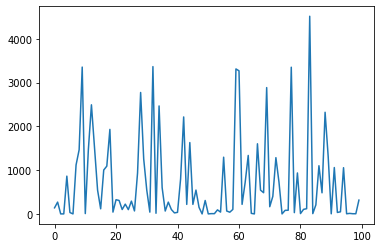

In [60]:
plt.plot(keep_track[0:100])

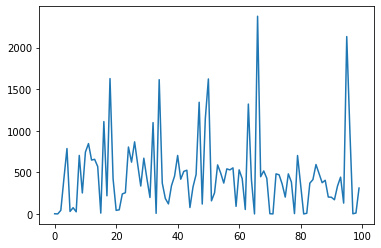

In [61]:
plt.plot(keep_track[8000:8100])